# **CNN Feature Extraction for Image Classification**

In this exercise, we will extract significant features from images with a CNN, and then we will use those features to classify the images with several standard machine learning classifiers.

Load the libraries, set the graphics to be plotted within the Jupyter notebook and fix the random seed to ensure the reproducibility of the results

In [1]:
%matplotlib inline
import os
import time
import datetime
import collections

from matplotlib import pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import models
from torchvision import datasets, transforms

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

We need to define the device where we are going to work. If a GPU is available we will always try to use it.

In [2]:
# the device where to execute
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

## **Data**

Establish the 10 classes that are available in the CIFAR10 dataset, see https://www.cs.toronto.edu/~kriz/cifar.html

In [3]:
class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

Download the training data for the CIFAR10 dataset, upzip it to the virtual folder ../data-unversioned/p1ch6/ and store it as the `cifar10` variable

In [4]:
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.4915, 0.4823, 0.4468),
                              (0.2470, 0.2435, 0.2616))]
                              )
    )

Files already downloaded and verified


Download the validation data for the CIFAR10 dataset, upzip it to the virtual folder ../data-unversioned/p1ch6/ and store it as the `cifar10_val` variable

In [5]:
cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.4915, 0.4823, 0.4468),
                              (0.2470, 0.2435, 0.2616))]
                              )
    )

Files already downloaded and verified


Select the classes that the CNN will classify, namely the **cat** (index 3), the **dog** (index 5) and **horse** (index 7) classes

Then extract a subset of the full training CIFAR10 dataset which contains the training samples of those three classes into the `cifar3` variable, and a subset of the full validation CIFAR10 dataset with the validation samples of these three classes into the `cifar3_val` variable

In [6]:
# classes we are going to use
class_names = ['cat', 'dog', 'horse']
# map from old labels to new labels
label_map = {3: 0, 5: 1, 7: 2}
# get only the classes we want and relabel them
cifar3 = [(img, label_map[label]) for img, label in cifar10 if label in label_map]
cifar3_val = [(img, label_map[label]) for img, label in cifar10_val if label in label_map]

Now lets see some examples of the subset we just created.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


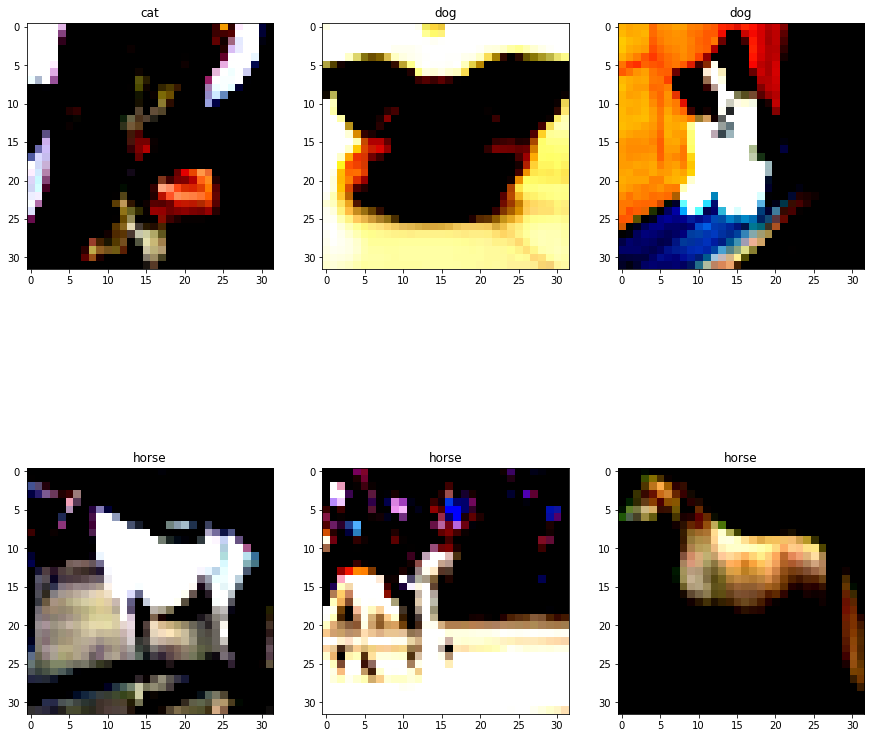

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,15))
for i in range(6):
  sample = cifar3[np.random.randint(len(cifar3))]
  axs[int(i/3), i%3].imshow(np.transpose(sample[0].numpy(),(1, 2, 0)))
  axs[int(i/3), i%3].set_title(class_names[sample[1]])

Finally we are going to create the data loaders that will help us in the training phase. The difference between the training loader and the calidation one, apart from the data they contain, is that the validation one should not be shuffled.

In [8]:
train_loader = torch.utils.data.DataLoader(cifar3, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar3_val, batch_size=64, shuffle=False)

## **VGG16**

In this section we are going to download the trained VGG16 and drop the classifier from the end, the fully connected layers at the end of the model.

First we need to download the VGG16.

In [9]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Now we are going to create our own features extractors using the trained convolutional layers of the VGG16. For that we will discard some parts of the model and cut it just after some of the convolutional layers.

In [10]:
class VGG16_sub(nn.Module):
  def __init__(self, layers=29):
    super().__init__()
    self.features = nn.Sequential(*list(vgg16.features.children())[:layers])

  def forward(self, x):
    out = self.features(x)
    return out.detach().cpu().flatten(1).numpy()

feat_extractors = {}
for i in [11, 15, 20, 25, 29]:
  feat_extractors[i] = VGG16_sub(i).to(device)

## **Features**

Lets pass through the features extractors an image to see the number of features we will get at the end.

In [11]:
# get the first image of the dataset
img, _ = cifar3[0]

# we will sabve it in here
n_feat = {}

for name, fe in feat_extractors.items():
  # forward
  output = fe(img.unsqueeze(0).to(device)).shape
  # save
  n_feat[name] = output[1]
print(n_feat)

{11: 16384, 15: 16384, 20: 8192, 25: 2048, 29: 2048}



We need to preprocess all the data to extract the features for each image in out datasets (training and validation).

In [12]:
def extract_features(model, dataloader):
  model.to(device)
  # get the number of features
  n_features = model(dataloader.dataset[0][0].unsqueeze(0).to(device)).shape[1]

  # create the containers
  X = np.zeros((0, n_features))
  y = np.zeros((0))

  for imgs, labels in dataloader:
    # move the images and labels to the device
    imgs = imgs.to(device)
    # extract features
    outputs = model(imgs)
    # create the final arrays of features and labels
    X = np.concatenate((X,outputs))
    y = np.concatenate((y, labels))

  return X, y

## **Train**

Now we will extract teh features with every one of the features extractors and train some traditional classifiers, then we will compare their performance.

In [15]:
data = {}

for name, fe in feat_extractors.items():
  print('----------------------------')
  print(f'{datetime.datetime.isoformat(datetime.datetime.now())} - Features extractor: {name}')
  # prepare a dict for the data
  data[name] = {}
  
  # lets copy here the number of features
  data[name]['n_features'] = n_feat[name]

  # extrac features for the training and validation datasets
  X_train, y_train = extract_features(fe, val_loader)
  X_val, y_val = extract_features(fe, val_loader)

  # the list of classifiers we will use
  classifiers = [GaussianNB(), KNeighborsClassifier(), DecisionTreeClassifier(), QuadraticDiscriminantAnalysis()]

  # train the different models and evaluate them in both training and evaluation datasets
  for cl in classifiers:
    print(f'{datetime.datetime.isoformat(datetime.datetime.now())} - Classifier: {cl.__class__.__name__}')
    # to save the data
    data[name][cl.__class__.__name__] = {}
    # train the model
    cl.fit(X_train, y_train)
    # evaluate
    data[name][cl.__class__.__name__]['train_score'] = cl.score(X_train,y_train)
    data[name][cl.__class__.__name__]['val_score'] = cl.score(X_val,y_val)
    print(data[name][cl.__class__.__name__])

----------------------------
2021-03-07T19:48:48.586695 - Features extractor: 11
2021-03-07T19:48:53.308750 - Classifier: GaussianNB
{'train_score': 0.7263333333333334, 'val_score': 0.7263333333333334}
2021-03-07T19:48:55.237907 - Classifier: KNeighborsClassifier
{'train_score': 0.7953333333333333, 'val_score': 0.7953333333333333}
2021-03-07T19:58:30.745592 - Classifier: DecisionTreeClassifier
{'train_score': 1.0, 'val_score': 1.0}
2021-03-07T19:59:25.414301 - Classifier: QuadraticDiscriminantAnalysis


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


{'train_score': 1.0, 'val_score': 1.0}
----------------------------
2021-03-07T19:59:58.399203 - Features extractor: 15
2021-03-07T20:00:03.178259 - Classifier: GaussianNB
{'train_score': 0.7686666666666667, 'val_score': 0.7686666666666667}
2021-03-07T20:00:05.130105 - Classifier: KNeighborsClassifier
{'train_score': 0.8213333333333334, 'val_score': 0.8213333333333334}
2021-03-07T20:09:39.537581 - Classifier: DecisionTreeClassifier
{'train_score': 1.0, 'val_score': 1.0}
2021-03-07T20:10:30.301884 - Classifier: QuadraticDiscriminantAnalysis


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


{'train_score': 1.0, 'val_score': 1.0}
----------------------------
2021-03-07T20:11:02.507218 - Features extractor: 20
2021-03-07T20:11:05.486672 - Classifier: GaussianNB
{'train_score': 0.7106666666666667, 'val_score': 0.7106666666666667}
2021-03-07T20:11:06.416456 - Classifier: KNeighborsClassifier
{'train_score': 0.8523333333333334, 'val_score': 0.8523333333333334}
2021-03-07T20:15:53.193200 - Classifier: DecisionTreeClassifier
{'train_score': 1.0, 'val_score': 1.0}
2021-03-07T20:16:27.270684 - Classifier: QuadraticDiscriminantAnalysis


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


{'train_score': 1.0, 'val_score': 1.0}
----------------------------
2021-03-07T20:16:43.649855 - Features extractor: 25
2021-03-07T20:16:45.323013 - Classifier: GaussianNB
{'train_score': 0.6946666666666667, 'val_score': 0.6946666666666667}
2021-03-07T20:16:45.574882 - Classifier: KNeighborsClassifier
{'train_score': 0.8283333333333334, 'val_score': 0.8283333333333334}
2021-03-07T20:17:56.440182 - Classifier: DecisionTreeClassifier
{'train_score': 1.0, 'val_score': 1.0}
2021-03-07T20:18:03.416333 - Classifier: QuadraticDiscriminantAnalysis


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


{'train_score': 1.0, 'val_score': 1.0}
----------------------------
2021-03-07T20:18:08.630047 - Features extractor: 29
2021-03-07T20:18:10.573017 - Classifier: GaussianNB
{'train_score': 0.6516666666666666, 'val_score': 0.6516666666666666}
2021-03-07T20:18:10.822400 - Classifier: KNeighborsClassifier
{'train_score': 0.8013333333333333, 'val_score': 0.8013333333333333}
2021-03-07T20:19:21.561018 - Classifier: DecisionTreeClassifier
{'train_score': 1.0, 'val_score': 1.0}
2021-03-07T20:19:28.993500 - Classifier: QuadraticDiscriminantAnalysis


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


{'train_score': 1.0, 'val_score': 1.0}


20:42

## **Results**

The table below shows teh values of evaluating each model in the training and the validation datasets. Those values are shown for the models trained with the features extracted with different depth of the VGG16 model.

Note: The two values are (training score, validation score).

In [26]:
from prettytable import PrettyTable

table = PrettyTable()

table.field_names = ['Feat Extractor/Classifier'] + [i.__class__.__name__ for i in classifiers]

for name, info in data.items():
  scores = [(round(v['train_score'], 2), round(v['val_score'],2)) for k,v in info.items() if isinstance(v, dict)]
  table.add_row(['{} - {} feat'.format(name, info['n_features'])] + scores)

print(table)

+---------------------------+--------------+----------------------+------------------------+-------------------------------+
| Feat Extractor/Classifier |  GaussianNB  | KNeighborsClassifier | DecisionTreeClassifier | QuadraticDiscriminantAnalysis |
+---------------------------+--------------+----------------------+------------------------+-------------------------------+
|      11 - 16384 feat      | (0.73, 0.73) |      (0.8, 0.8)      |       (1.0, 1.0)       |           (1.0, 1.0)          |
|      15 - 16384 feat      | (0.77, 0.77) |     (0.82, 0.82)     |       (1.0, 1.0)       |           (1.0, 1.0)          |
|       20 - 8192 feat      | (0.71, 0.71) |     (0.85, 0.85)     |       (1.0, 1.0)       |           (1.0, 1.0)          |
|       25 - 2048 feat      | (0.69, 0.69) |     (0.83, 0.83)     |       (1.0, 1.0)       |           (1.0, 1.0)          |
|       29 - 2048 feat      | (0.65, 0.65) |      (0.8, 0.8)      |       (1.0, 1.0)       |           (1.0, 1.0)          |


A couple of classifiers (DecisionTreeClassifier and QuadraticDiscriminantAnalysis) obtain very good results with independence of the nmber of features and if they are high level or low level. 

The other two classifiers obtains better performance when the features are extracted from the middle of the VGG16, in the 15th and 20th layers. That means that they perform the best when the features are nor really high level or really low level.

Another thing to notice is the training time. Obviously the number of features drives the time to train the models but in the special case of the KNeighborsClassifier the time grows exponentially which may be critical if we have to decide the number of features or the algorithm we want to use to classify.